In [47]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [7]:
user = pd.read_json('user.json')
user.head(5)

,ID,tweet,profile
0,15750898,[A family fears they may have been cheated out...,"{'id': 15750898, 'id_str': '15750898', 'name':..."
1,1659167666,[RT @VonteThePlug: Yeah but he ain’t got one h...,"{'id': 1659167666, 'id_str': '1659167666', 'na..."
2,34743251,"[RT @elonmusk: Aloha, welcome back from space ...","{'id': 34743251, 'id_str': '34743251', 'name':..."
3,207809313,[एक राष्ट्र - एक राशन कार्ड की ओर अग्रसर भारत\...,"{'id': 207809313, 'id_str': '207809313', 'name..."
4,24212655,[RT @dominiquecrenn: So much negativity and go...,"{'id': 24212655, 'id_str': '24212655', 'name':..."


In [18]:
### Part 1 选择需要分析的individual trait
location = []
for i in range(len(user)):
    if user['profile'][i]==None:
        location.append('Unknown')
        continue
    location.append(user['profile'][i]['location'])

In [20]:
user['location'] = location
user.head(5)

,ID,tweet,profile,location
0,15750898,[A family fears they may have been cheated out...,"{'id': 15750898, 'id_str': '15750898', 'name':...","Tampa, FL"
1,1659167666,[RT @VonteThePlug: Yeah but he ain’t got one h...,"{'id': 1659167666, 'id_str': '1659167666', 'na...","Jacksonville Beach, FL"
2,34743251,"[RT @elonmusk: Aloha, welcome back from space ...","{'id': 34743251, 'id_str': '34743251', 'name':...","Hawthorne, CA"
3,207809313,[एक राष्ट्र - एक राशन कार्ड की ओर अग्रसर भारत\...,"{'id': 207809313, 'id_str': '207809313', 'name...","6-A, Deen Dayal Upadhyay Marg,"
4,24212655,[RT @dominiquecrenn: So much negativity and go...,"{'id': 24212655, 'id_str': '24212655', 'name':...","Chicago, Illinois"


In [24]:
trait = user[['ID', 'location']]
bot_label = pd.read_csv('train.csv', sep='\t')
user_with_label = pd.merge(trait, bot_label, on='ID', how='inner')
user_with_label['Label'].value_counts()

0    6908
1    1829
Name: Label, dtype: int64

In [27]:
edge = pd.read_json('edge.json')
edge.head()

,seed_user_id,relation,relation_user_id
0,15750898,followers,2324715174
1,15750898,friends,1279902697991409664
2,1659167666,followers,329721192
3,1659167666,followers,396721750
4,1659167666,friends,243412850


In [39]:
# 处理成(2, E)的数据，其中第0行节点follow第1行节点
followers = edge[edge['relation']=='followers']
friends = edge[edge['relation']=='friends']

In [44]:
edges_1 = np.array([followers['relation_user_id'].to_list(),followers['seed_user_id'].to_list()])
edges_2 = np.array([friends['seed_user_id'].to_list(),friends['relation_user_id'].to_list()])
edges = np.concatenate([edges_1, edges_2], axis=1)

In [111]:
# check the label
a = list(edges[0])
b = list(edges[1])
c = user_with_label['ID'].to_list()
followers_label = set(a)&set(c)
followed_label = set(b)&set(c)
followers_label&followed_label
## TODO: 这个数据集tie两端都有身份label的只有86个

In [68]:
# 创建一个空的NetworkX图
G = nx.DiGraph()

# 添加节点及其属性
for index, row in user_with_label.iterrows():
    G.add_node(row['ID'], feature=row['location'], label=row['Label'])

# 添加边
for e in range(len(edges[0])):
    G.add_edge(edges[0][e], edges[1][e])

print('Num Nodes:', len(G.nodes))
print('Num Edges:', len(G.edges))

Num Nodes: 24696
Num Edges: 17792


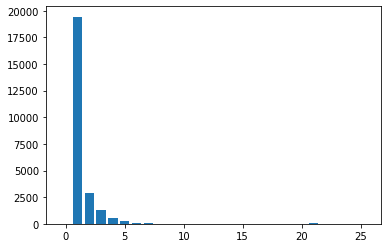

In [141]:
degree_hist = nx.degree_histogram(G)

# 绘制直方图
plt.bar(range(len(degree_hist)), degree_hist)
plt.show()

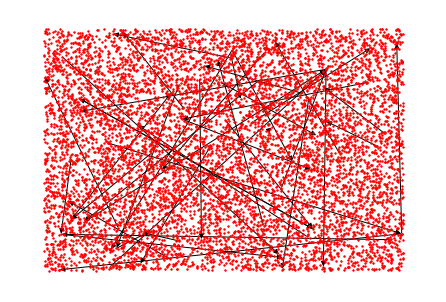

In [140]:
# 获取标签为 "A" 的节点
# 获取节点的标签值
node_labels = nx.get_node_attributes(G, "label")

# 获取标签为 "A" 的节点
nodes_to_draw1 = [n for n, v in node_labels.items() if v == 1]
nodes_to_draw0 = [n for n, v in node_labels.items() if v == 0]

subgraph = G.subgraph(nodes_to_draw1+nodes_to_draw0)

# 获取标签为 "A" 的节点相连的边
#edges_to_draw = [(u, v) for u, v in G.edges() if u in nodes_to_draw1 and v in nodes_to_draw0]

# 绘制图形
# nx.draw_networkx_nodes(G, pos=nx.spring_layout(G), nodelist=nodes_to_draw1, node_color="r")
# print("1")
# nx.draw_networkx_nodes(G, pos=nx.spring_layout(G), nodelist=nodes_to_draw0, node_color="b")
# print("2")
#nx.draw_networkx_edges(G, pos=nx.random_layout(G), edgelist=edges_to_draw)
nx.draw(subgraph, pos=nx.random_layout(subgraph), node_color="r", node_size=2)
# 显示图形
plt.show()